<a href="https://colab.research.google.com/github/MonikSense/Diabetes/blob/main/diabetesvalidation602020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

✅ Target column detected as: diabetes
Train: (70000, 8), Validation: (15000, 8), Test: (15000, 8)

🔍 Grid Search for Logi

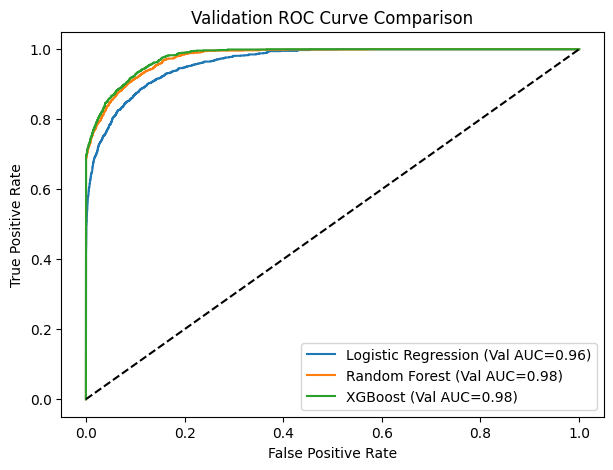

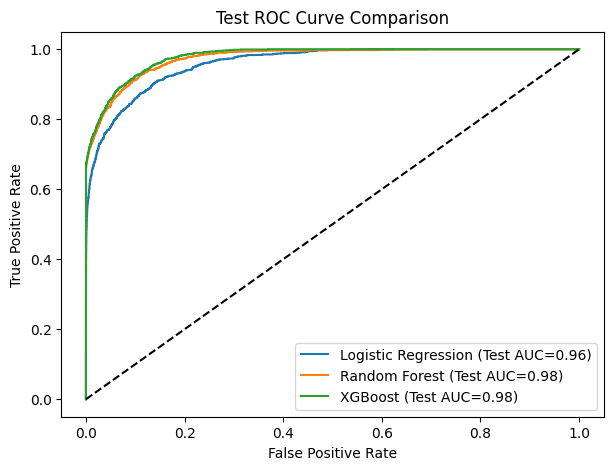

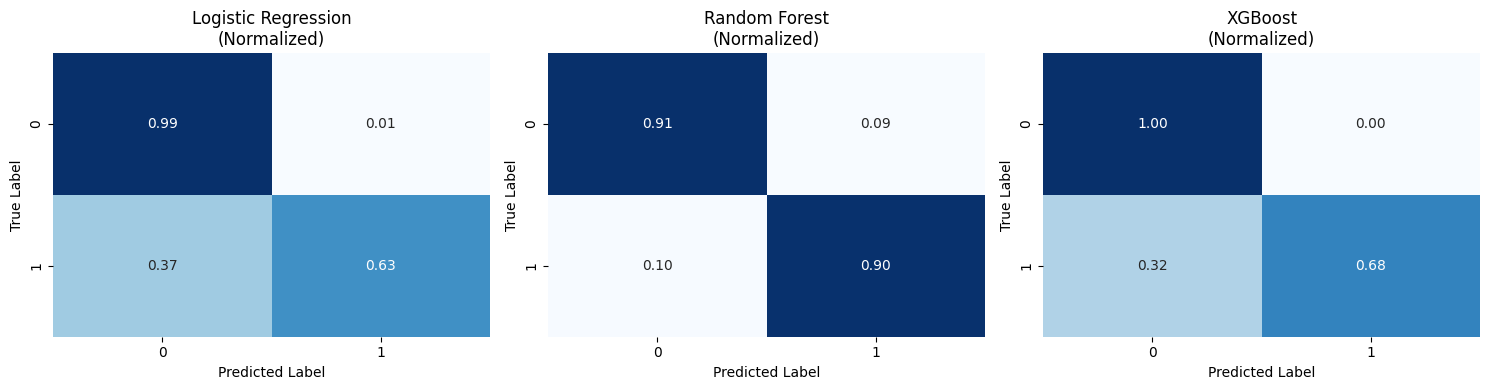

In [1]:
# ============================
# Diabetes Prediction with Train-Validation-Test Split + Grid Search
# ============================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 2️⃣ Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/MonikSense/Diabetes/refs/heads/main/diabetes_prediction_dataset.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 3️⃣ Detect Target Column
possible_targets = ["diabetes"]
target_col = None
for col in df.columns:
    if col.strip().capitalize() in [p.capitalize() for p in possible_targets]:
        target_col = col
        break

if target_col is None:
    raise ValueError("⚠️ Target column 'diabetes' not found! Please specify manually.")

print(f"\n✅ Target column detected as: {target_col}")

# 4️⃣ Define Features and Target
X = df.drop(columns=[target_col])
y = df[target_col]

# 5️⃣ Handle Missing Values
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# 6️⃣ Split Data: Train, Validation, Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# 7️⃣ Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 8️⃣ Define Base Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='auc', random_state=42)
}

# 9️⃣ Define Grid Search Parameters
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1.0, 10],
        'penalty': ['l2']
    },
    "Random Forest": {
        'n_estimators': [100, 300],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 4],
        'class_weight': ['balanced']
    },
    "XGBoost": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
}

# 🔟 Automated Grid Search on Validation Set
best_models = {}
for name, model in models.items():
    print(f"\n🔍 Grid Search for {name}...")
    grid = GridSearchCV(model, param_grids[name],
                        scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

    if name == "Random Forest":
        grid.fit(X_train, y_train)
    else:
        grid.fit(X_train_scaled, y_train)

    best_models[name] = grid.best_estimator_
    print(f"✅ Best Params for {name}: {grid.best_params_}")
    print(f"Validation AUC: {grid.best_score_:.3f}")

# 11️⃣ Evaluate Models on Validation and Test Sets
results = {}
for name, model in best_models.items():
    if name == "Random Forest":
        Xv, Xt = X_val, X_test
    else:
        Xv, Xt = X_val_scaled, X_test_scaled

    # Validation predictions
    yv_pred = model.predict(Xv)
    yv_prob = model.predict_proba(Xv)[:, 1]

    # Test predictions
    yt_pred = model.predict(Xt)
    yt_prob = model.predict_proba(Xt)[:, 1]

    results[name] = {
        "val_acc": accuracy_score(y_val, yv_pred),
        "val_auc": roc_auc_score(y_val, yv_prob),
        "test_acc": accuracy_score(y_test, yt_pred),
        "test_auc": roc_auc_score(y_test, yt_prob),
        "confusion": confusion_matrix(y_test, yt_pred)
    }

    print(f"\n🔹 {name}")
    print("Validation Accuracy:", round(results[name]["val_acc"], 3))
    print("Validation AUC:", round(results[name]["val_auc"], 3))
    print("Test Accuracy:", round(results[name]["test_acc"], 3))
    print("Test AUC:", round(results[name]["test_auc"], 3))
    print("Classification Report:\n", classification_report(y_test, yt_pred))

# 12️⃣ Validation ROC Curves
plt.figure(figsize=(7,5))
for name, model in best_models.items():
    if name == "Random Forest":
        y_prob = model.predict_proba(X_val)[:, 1]
    else:
        y_prob = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (Val AUC={results[name]['val_auc']:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve Comparison")
plt.legend()
plt.show()

# 13️⃣ Test ROC Curves
plt.figure(figsize=(7,5))
for name, model in best_models.items():
    if name == "Random Forest":
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (Test AUC={results[name]['test_auc']:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve Comparison")
plt.legend()
plt.show()

# 14️⃣ Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, res) in zip(axes, results.items()):
    cm = res["confusion"]
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"{name}\n(Normalized)")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()
